# Stacking Sats Challenge

### Strategy Development Template

**Hosted on [Hypertrial.ai](https://www.hypertrial.ai/)**

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hypertrial/stacking_sats_challenge/blob/main/tutorials/4.%20Strategy%20Development%20Template.ipynb)

[![YouTube](https://img.shields.io/badge/Watch%20on-YouTube-red?logo=youtube&logoColor=white)](https://youtu.be/qJp8W83f3Fw?si=Wzo8ORKwFLHhBoM0)

Welcome to the official submission template for the Stacking Sats Challenge.  
This notebook replicates the structure used by the evaluation engine to test all participant strategies.

---

## ✅ What You’ll Learn

By the end of this tutorial, you will:

- Understand the **boilerplate code** and what is already provided (e.g. imports, data loading, global config)
- Learn where and how to **insert your own strategy logic**
- Run **backtests and visualizations** to debug and assess performance
- Ensure your submission is **valid, testable, and reproducible**

---

## 🛠️ What You’re Expected to Do

- **Modify only the strategy function** inside the provided cell  
- Leave all boilerplate (e.g. registration, config, data loading) unchanged
- Submit your **dynamic_rule_causal** function for evaluation on [Hypertrial.ai]('https://www.hypertrial.ai/')

This structure guarantees consistency, fairness, and ease of comparison across all submitted models.

---

> ⚠️ Do not change function names, decorators, or global config values unless explicitly allowed.  
> Your entry must adhere to this template to be considered valid.


### 🚫 Boilerplate Code — Do Not Modify

In [4]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# core/config.py
# ---------------------------

# ╔═════════════════════╗
# ║  Global Variables   ║
# ╚═════════════════════╝

BACKTEST_START = '2013-01-01'
BACKTEST_END = '2024-12-31'
CYCLE_YEARS = 4 # Investment Duration 
PURCHASE_FREQ = 'Daily' # Yet to be added in code 
MIN_WEIGHT = 1e-5 # PURCHASE_FREQ minimum investment 

In [5]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# Extract BTC data from CoinMetrics and save locally
# ---------------------------
import pandas as pd 
import logging
from datetime import datetime
import requests # new import 
from io import StringIO # new import

try:
    from coinmetrics.api_client import CoinMetricsClient
except ImportError:
    raise ImportError("coinmetrics.api_client module is required. Install it via pip:\n\n    pip install coinmetrics-api-client")

# Configure logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

def extract_btc_data_to_csv(local_path='btc_data.csv'):
    # Coin Metrics BTC CSV (raw GitHub URL)
    url = "https://raw.githubusercontent.com/coinmetrics/data/master/csv/btc.csv"
    
    # Download the content
    response = requests.get(url)
    response.raise_for_status()  # raises an error for bad responses
    
    # Parse CSV content
    btc_df = pd.read_csv(StringIO(response.text))

    btc_df['time'] = pd.to_datetime(btc_df['time']).dt.normalize()
    btc_df['time'] = btc_df['time'].dt.tz_localize(None)
    btc_df.set_index('time', inplace=True)

    btc_df.to_csv(local_path)
    
    # Show the df
    btc_df

btc_df = extract_btc_data_to_csv("btc_data.csv")

/var/folders/zn/3r5r5myd1dq34m6jv1g5rq7m0000gn/T/ipykernel_73994/4179518580.py:32: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  btc_df = pd.read_csv(StringIO(response.text))


In [6]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# core/data.py
# ---------------------------
import pandas as pd
import numpy as np
import logging

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

def load_data():
    df = pd.read_csv("btc_price_data.csv", index_col=0, parse_dates=True)
    df = df.loc[~df.index.duplicated(keep='last')]
    df = df.sort_index()
    return df

def validate_price_data(df):
    if df.empty or 'PriceUSD' not in df.columns:
        raise ValueError("Invalid BTC price data.")
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be datetime.")

# Global Variable to use later
df = load_data() 

/var/folders/zn/3r5r5myd1dq34m6jv1g5rq7m0000gn/T/ipykernel_73994/948387648.py:16: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("btc_price_data.csv", index_col=0, parse_dates=True)


In [7]:
# ---------------------------
# core/spd.py
# ---------------------------

# ╔═════════════╗
# ║  Imports    ║
# ╚═════════════╝
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ╔════════════════════════════════════════════════════╗
# ║  Main helpers – cycle length driven by CYCLE_YEARS ║
# ╚════════════════════════════════════════════════════╝
def _make_cycle_label(start, end, cycle_years):
    """Return a pretty label for a cycle of arbitrary length."""
    if cycle_years == 1:
        return f"{start.year}"
    return f"{start.year}–{end.year}"


def compute_cycle_spd(df, strategy_fn, *, cycle_years: int = CYCLE_YEARS):
    """
    Compute SPD stats per cycle of length `cycle_years`.
    """
    df_backtest = df.loc[BACKTEST_START:BACKTEST_END]
    cycle_length = pd.DateOffset(years=cycle_years)

    current = df_backtest.index.min()
    rows = []

    full_weights = strategy_fn(df)#.fillna(0).clip(lower=0)
    inverted_prices = (1 / df_backtest["PriceUSD"]) * 1e8  # satoshi-per-dollar

    while current <= df_backtest.index.max():
        cycle_end = current + cycle_length - pd.Timedelta(days=1)
        end_date = min(cycle_end, df_backtest.index.max())

        cycle_mask = (df_backtest.index >= current) & (df_backtest.index <= end_date)
        cycle = df_backtest.loc[cycle_mask]
        if cycle.empty:
            break

        #label = _plot_cycle_label(current, cycle_years)
        label = _make_cycle_label(current, end_date, cycle_years)

        prices = cycle["PriceUSD"].values
        high, low = np.max(prices), np.min(prices)
        min_spd, max_spd = (1 / high) * 1e8, (1 / low) * 1e8

        cycle_inv = inverted_prices.loc[cycle.index]
        w_slice = full_weights.loc[cycle.index]

        dynamic_spd = (w_slice * cycle_inv).sum()
        uniform_spd = cycle_inv.mean()

        spd_range = max_spd - min_spd
        uniform_pct = (uniform_spd - min_spd) / spd_range * 100
        dynamic_pct = (dynamic_spd - min_spd) / spd_range * 100
        excess_pct = dynamic_pct - uniform_pct

        rows.append(
            {
                "cycle": label,
                "min_spd": min_spd,
                "max_spd": max_spd,
                "uniform_spd": uniform_spd,
                "dynamic_spd": dynamic_spd,
                "uniform_pct": uniform_pct,
                "dynamic_pct": dynamic_pct,
                "excess_pct": excess_pct,
            }
        )

        current += cycle_length

    return pd.DataFrame(rows).set_index("cycle")


def backtest_dynamic_dca(
    df, strategy_fn, *, strategy_label: str = "your_strategy", cycle_years: int = CYCLE_YEARS
):
    """
    Convenience wrapper: print aggregate stats and return the cycle table.
    """
    res = compute_cycle_spd(df, strategy_fn, cycle_years=cycle_years)

    dyn_spd = res["dynamic_spd"]
    dyn_pct = res["dynamic_pct"]

    print(f"\nAggregated Metrics for {strategy_label}:")
    print("Dynamic SPD:")
    for k in ["min", "max", "mean", "median"]:
        print(f"  {k}: {getattr(dyn_spd, k)():.2f}")
    print("Dynamic SPD Percentile:")
    for k in ["min", "max", "mean", "median"]:
        print(f"  {k}: {getattr(dyn_pct, k)():.2f}")

    print("\nExcess SPD Percentile Difference (Dynamic – Uniform) per Cycle:")
    for cycle, row in res.iterrows():
        print(f"  {cycle}: {row['excess_pct']:.2f}%")

    return res


def check_strategy_submission_ready(
    df, strategy_fn, *, cycle_years: int = CYCLE_YEARS
):
    """
    Sanity-check that a strategy:
      • has strictly positive weights ≥ MIN_WEIGHT
      • weights per cycle sum ≈ 1
      • beats uniform DCA on SPD percentile
    """
    df_backtest = df.loc[BACKTEST_START:BACKTEST_END]
    cycle_length = pd.DateOffset(years=cycle_years)

    current = df_backtest.index.min()
    full_weights = strategy_fn(df).fillna(0)

    passed = True

    while current <= df_backtest.index.max():
        cycle_end = current + cycle_length - pd.Timedelta(days=1)
        end_date = min(cycle_end, df_backtest.index.max())

        label = _make_cycle_label(current, end_date, cycle_years)

        mask = (df_backtest.index >= current) & (df_backtest.index <= end_date)
        w_slice = full_weights.loc[df_backtest.loc[mask].index]

        if (w_slice <= 0).any():
            print(f"[{label}] ❌ Some weights are zero or negative.")
            passed = False

        if (w_slice < MIN_WEIGHT).any():
            print(f"[{label}] ❌ Some weights are below MIN_WEIGHT = {MIN_WEIGHT}.")
            passed = False

        tot_wt = w_slice.sum().sum() if isinstance(w_slice, pd.DataFrame) else w_slice.sum()
        if not np.isclose(tot_wt, 1.0, rtol=1e-5, atol=1e-8):
            print(f"[{label}] ❌ Total weights do not sum to 1 (sum = {tot_wt:.6f}).")
            passed = False

        current += cycle_length

    spd_res = compute_cycle_spd(df, strategy_fn, cycle_years=cycle_years)
    for cycle, row in spd_res.iterrows():
        if row["dynamic_pct"] < row["uniform_pct"]:
            print(
                f"[{cycle}] ❌ Dynamic SPD percentile ({row['dynamic_pct']:.2f}%) "
                f"is less than uniform ({row['uniform_pct']:.2f}%)."
            )
            passed = False

    print("✅ Strategy is ready for submission." if passed else "⚠️ Fix issues above.")

In [8]:
# ---------------------------
# core/plots.py
# ---------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────────────────────
# helpers
# ──────────────────────────────────────────────────────────────────────────────
def _plot_cycle_label(start_year: int, cycle_idx: int) -> str:
    """
    Pretty cycle label for arbitrary cycle length.
    """
    first = start_year + CYCLE_YEARS * cycle_idx
    if CYCLE_YEARS == 1:
        return f"{first}"
    return f"{first}–{first + CYCLE_YEARS - 1}"


def _cycle_idx(timestamp, start_year):
    """
    Integer cycle index for a timestamp relative to the first back-test year.
    """
    return (timestamp.year - start_year) // CYCLE_YEARS


# ──────────────────────────────────────────────────────────────────────────────
# plotting utilities
# ──────────────────────────────────────────────────────────────────────────────

def plot_features(
    df,
    weights=None,
    *,
    start_date: str | pd.Timestamp = BACKTEST_START,
    end_date: str | pd.Timestamp = BACKTEST_END,
):
    """
    Plot BTC price vs. the first derived feature within the chosen back-test window.

    Parameters
    ----------
    df : pd.DataFrame
        Raw BTC price dataframe (`PriceUSD` must be present).
    weights : pd.Series or None, optional
        Daily weight series aligned on the same index as `df` (used only for
        marker styling). If provided, it is automatically trimmed to the same
        date window.
    start_date, end_date : str or pd.Timestamp, optional
        Window to plot.  Defaults to BACKTEST_START / BACKTEST_END from config.
    """
    # Build features first, then trim to the requested window
    df = construct_features(df).loc[start_date:end_date]

    # Trim weights (if any) to the same index
    if weights is not None:
        weights = weights.loc[df.index]

    feature_name = df.columns[1]

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(f"BTC Price and {feature_name}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")

    # Main series
    ax.plot(df.index, df["PriceUSD"], label="BTC Price", color="black", alpha=0.7)
    ax.plot(df.index, df[feature_name], label=feature_name, color="orange", alpha=0.7)

    # Highlight regions where the feature value exceeds price
    signal = df["PriceUSD"] < df[feature_name]
    ax.fill_between(
        df.index,
        df["PriceUSD"],
        df[feature_name],
        where=signal,
        color="green",
        alpha=0.1,
    )

    # Optional weight markers (colour-coded by the same signal for now)
    if weights is not None:
        ax.scatter(
            df.index[~signal],
            df.loc[~signal, "PriceUSD"],
            marker="o",
            facecolors="none",
            edgecolors="blue",
            label="Uniform",
        )
        ax.scatter(
            df.index[signal],
            df.loc[signal, "PriceUSD"],
            marker="o",
            color="red",
            label="Dynamic",
        )

    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


def plot_final_weights(
    weights: pd.Series,
    *,
    start_date: str | pd.Timestamp = BACKTEST_START,
    cycle_years: int = CYCLE_YEARS,
):
    """
    Plot daily position weights with one curve per investment cycle and show
    a horizontal dashed line at the global MIN_WEIGHT threshold.
    """
    # ── helpers ─────────────────────────────────────────────────────────────
    def _cycle_idx(ts, first_year):
        return (ts.year - first_year) // cycle_years

    def _cycle_label(first_year, idx):
        first = first_year + cycle_years * idx
        return f"{first}" if cycle_years == 1 else f"{first}–{first + cycle_years - 1}"

    # ── compute cycle labels ───────────────────────────────────────────────
    start_year = pd.to_datetime(start_date).year
    cycle_indices = weights.index.to_series().apply(lambda dt: _cycle_idx(dt, start_year))

    # ── plot ───────────────────────────────────────────────────────────────
    cmap = plt.get_cmap("tab10")
    fig, ax = plt.subplots(figsize=(12, 5))

    for idx, group in weights.groupby(cycle_indices):
        label = _cycle_label(start_year, idx)
        ax.plot(group.index, group.values, label=label, color=cmap(idx % 10))

        # per-cycle uniform weight baseline
        uniform = 1.0 / len(group)
        ax.hlines(
            uniform,
            group.index.min(),
            group.index.max(),
            color=cmap(idx % 10),
            linestyle="--",
            alpha=0.5,
        )

    # global MIN_WEIGHT threshold (one line across the whole plot)
    ax.axhline(
        MIN_WEIGHT,
        color="black",
        linestyle="--",
        linewidth=1,
        label=f"MIN_WEIGHT = {MIN_WEIGHT:g}",
    )

    ax.set_title("Final Daily Weights")
    
    labels = list(weights.groupby(cycle_indices).groups.keys())
    n_labels = len(labels) + 1  # +1 for MIN_WEIGHT line
    
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.00),
        ncol=n_labels,
        fontsize="small",
        frameon=True,
        handlelength=1.5,
        columnspacing=1.2
    )


    ax.grid(True)
    plt.tight_layout()
    plt.show()

def plot_weight_sums_by_cycle(
    weights,
    *,
    start_date: str | pd.Timestamp = BACKTEST_START,
    cycle_years: int = CYCLE_YEARS,
):
    """
    Bar-plot showing the sum of daily weights inside each investment cycle.

    Parameters
    ----------
    weights : pd.Series
        Daily weight series indexed by date.
    start_date : str or pd.Timestamp, optional
        First day of the back-test (default = BACKTEST_START).
    cycle_years : int, optional
        Length of each investment cycle (default = CYCLE_YEARS).
    """
    # ── helpers ───────────────────────────────────────────────────────────
    def _cycle_idx(ts, first_year):
        return (ts.year - first_year) // cycle_years

    def _cycle_label(first_year, idx):
        first = first_year + cycle_years * idx
        return f"{first}" if cycle_years == 1 else f"{first}–{first + cycle_years - 1}"

    # ── aggregate sums ────────────────────────────────────────────────────
    start_year = pd.to_datetime(start_date).year
    cycle_indices = weights.index.to_series().apply(lambda dt: _cycle_idx(dt, start_year))
    weight_sums = weights.groupby(cycle_indices).sum()

    # ── console printout ──────────────────────────────────────────────────
    print("Cycle Weight Sums:")
    for idx, total in weight_sums.items():
        print(f"  {_cycle_label(start_year, idx)}: {total:.4f}")

    # ── plot ──────────────────────────────────────────────────────────────
    labels = [_cycle_label(start_year, idx) for idx in weight_sums.index]
    plt.bar(labels, weight_sums.values, alpha=0.7)
    plt.axhline(1.0, linestyle="--", color="black", label="Target: 1.0")
    plt.title("Weight Sums by Cycle")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_spd_comparison(
    df_res: pd.DataFrame,
    strategy_name: str = "Dynamic",
    *,
    cycle_years: int = CYCLE_YEARS,
):
    """
    Compare uniform vs. dynamic DCA in sats-per-dollar space and percentile space.
    """
    x = np.arange(len(df_res))
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_yscale("log")

    # ── SPD curves in desired order: max ▸ dynamic ▸ uniform ▸ min ──────────
    lines = ax1.plot(
        x, df_res["max_spd"],     "o-",
        x, df_res["dynamic_spd"], "o-",
        x, df_res["uniform_spd"], "o-",
        x, df_res["min_spd"],     "o-",
    )

    ax1.set_title(f"Uniform vs {strategy_name} DCA (SPD)")
    ax1.set_ylabel("Sats per Dollar (log scale)")
    ax1.set_xlabel("Cycle" if cycle_years == 1 else f"Cycle ({cycle_years}-yr)")
    ax1.grid(True, linestyle="--", linewidth=0.5)

    ax1.legend(
        lines,
        ["Max spd (Low)", strategy_name, "Uniform DCA spd", "Min spd (High)"],
        loc="upper left",
    )

    ax1.set_xticks(x)
    ax1.set_xticklabels(df_res.index, rotation=15, ha="right")

    # ── Percentile bars ────────────────────────────────────────────────────
    ax2 = ax1.twinx()
    bar_w = 0.4
    bar1  = ax2.bar(x - bar_w / 2, df_res["uniform_pct"],  width=bar_w, alpha=0.3)
    bar2  = ax2.bar(x + bar_w / 2, df_res["dynamic_pct"], width=bar_w, alpha=0.3)

    ax2.set_ylabel("SPD Percentile (%)")
    ax2.set_ylim(0, 100)
    ax2.legend([bar1, bar2], ["Uniform %", f"{strategy_name} %"], loc="upper right")

    plt.tight_layout()
    plt.show()

# ✍️ User Code — Implement Your Strategy Logic Below

In [10]:
import pandas as pd 
import numpy as np
from typing import Dict, Any
#from core.config import BACKTEST_START, BACKTEST_END, MIN_WEIGHT
#from core.strategies import register_strategy

def construct_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Construct technical indicators used for the strategy.
    Uses only past data for calculations to avoid look-ahead bias.
    
    Args:
        df: DataFrame with price data
        
    Returns:
        DataFrame with added technical indicators
    """
    df = df.copy()

    # Extract relevant features (using only price here) 
    df = df[['PriceUSD']]
    
    # Shift the PriceUSD column by one to use only past data for our calculations
    past_price = df['PriceUSD'].shift(1)
    # Calculate 200-day moving average
    df['ma200'] = past_price.rolling(window=200, min_periods=1).mean()
    # Calculate 200-day standard deviation
    df['std200'] = past_price.rolling(window=200, min_periods=1).std()
    return df

# Example Ethereum wallet address - replace with real one for actual submissions
#ETH_WALLET_ADDRESS = "0x71C7656EC7ab88b098defB751B7401B5f6d8976F"

#@register_strategy(ETH_WALLET_ADDRESS)
def compute_weights(df: pd.DataFrame) -> pd.Series:
    """
    Computes daily DCA weights with a 200-day moving average strategy.
    Increases weight on days when price is below MA, redistributing from future days.
    
    Strategy logic:
    1. Start with uniform weights across each market cycle
    2. For days when price < 200MA, boost weight proportional to distance below MA
    3. Redistribute the excess weight from future days within a rebalance window
    4. Maintain minimum weight constraints for all days
    
    Args:
        df: DataFrame with BTC price data
        
    Returns:
        Series of daily investment weights, summing to 1.0 per market cycle
    """
    # Strategy parameters
    REBALANCE_WINDOW = (CYCLE_YEARS*365)//2 
    # Redistribute weight from up to 2 years ahead
    ALPHA = 1.25  # Multiplier for how much to boost weight based on z-score
    
    df_work = df.copy()
    df_work = construct_features(df)
    
    # Filter to backtest period only
    df_backtest = df_work.loc[BACKTEST_START:BACKTEST_END]
    weights = pd.Series(index=df_backtest.index, dtype=float)
    
    # Group by 4-year market cycles
    start_year = pd.to_datetime(BACKTEST_START).year
    cycle_labels = df_backtest.index.to_series().apply(lambda dt: (dt.year - start_year) // 4)
    
    # Process each market cycle separately to maintain weight sum = 1.0 per cycle
    for cycle, group in df_backtest.groupby(cycle_labels):
        N = len(group)
        base_weight = 1.0 / N  # Start with uniform weight distribution
        temp_weights = np.full(N, base_weight)
        strategy_active = True  # Flag to stop adjustments if constraints can't be met
        
        # Process each day in the cycle
        for i in range(N):
            if not strategy_active:
                break
            
            price = group['PriceUSD'].iloc[i]
            ma200 = group['ma200'].iloc[i]
            std200 = group['std200'].iloc[i]
            
            # Skip days with insufficient history
            if pd.isna(ma200) or pd.isna(std200) or std200 <= 0:
                continue
            
            # Apply weight boost when price is below MA
            if price < ma200:
                # Calculate z-score (standard deviations below MA)
                z = (ma200 - price) / std200
                boost_multiplier = 1 + ALPHA * z
                current_weight = temp_weights[i]
                boosted_weight = current_weight * boost_multiplier
                excess = boosted_weight - current_weight
                
                # Determine which future days to redistribute from
                start_redistribution = max(N - REBALANCE_WINDOW, i + 1)
                if start_redistribution >= N:
                    continue  # No future days to redistribute from
                
                redistribution_idx = np.arange(start_redistribution, N)
                if len(redistribution_idx) == 0:
                    continue
                    
                # Calculate reduction per future day
                reduction = excess / len(redistribution_idx)
                projected = temp_weights[redistribution_idx] - reduction
                
                # Only apply changes if minimum weight constraint is satisfied
                if np.all(projected >= MIN_WEIGHT):
                    temp_weights[i] = boosted_weight
                    temp_weights[redistribution_idx] -= reduction
                else:
                    # Stop strategy adjustments if constraints can't be met
                    strategy_active = False
        
        # Assign weights back to the original index
        weights.loc[group.index] = temp_weights
    
    return weights

def compute_weights(df: pd.DataFrame, *, cycle_years: int = CYCLE_YEARS) -> pd.Series:
    """
    Dynamic-DCA weights based on 200-day MA distance.
    Sums to 1 **within each `cycle_years` block**.
    """
    # ── params ──────────────────────────────────────────────────────────
    REBALANCE_WINDOW = max(int(cycle_years * 365) // 2, 1)   # half the cycle
    ALPHA            = 1.25
    # ── features ────────────────────────────────────────────────────────
    df_feat   = construct_features(df).loc[BACKTEST_START:BACKTEST_END]
    weights   = pd.Series(index=df_feat.index, dtype=float)

    start_year   = pd.to_datetime(BACKTEST_START).year
    cycle_labels = df_feat.index.to_series().apply(
        lambda ts: (ts.year - start_year) // cycle_years
    )

    # ── loop over cycles ────────────────────────────────────────────────
    for _, cycle_df in df_feat.groupby(cycle_labels):
        N           = len(cycle_df)
        base_wt     = 1.0 / N
        temp_wt     = np.full(N, base_wt)

        for day in range(N):
            price, ma, sd = (
                cycle_df["PriceUSD"].iat[day],
                cycle_df["ma200"].iat[day],
                cycle_df["std200"].iat[day],
            )
            if pd.isna(ma) or pd.isna(sd) or sd == 0 or price >= ma:
                continue

            z         = (ma - price) / sd
            boosted   = temp_wt[day] * (1 + ALPHA * z)
            excess    = boosted - temp_wt[day]

            # redistribute from the **last part of the SAME cycle**
            start_r   = max(N - REBALANCE_WINDOW, day + 1)
            idx_r     = np.arange(start_r, N)
            if len(idx_r) == 0:
                continue
            reduction = excess / len(idx_r)
            if np.all(temp_wt[idx_r] - reduction >= MIN_WEIGHT):
                temp_wt[day]          = boosted
                temp_wt[idx_r]       -= reduction

        weights.loc[cycle_df.index] = temp_wt

    return weights

### 🚫 Boilerplate Code — Do Not Modify

/var/folders/zn/3r5r5myd1dq34m6jv1g5rq7m0000gn/T/ipykernel_73994/948387648.py:16: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("btc_price_data.csv", index_col=0, parse_dates=True)


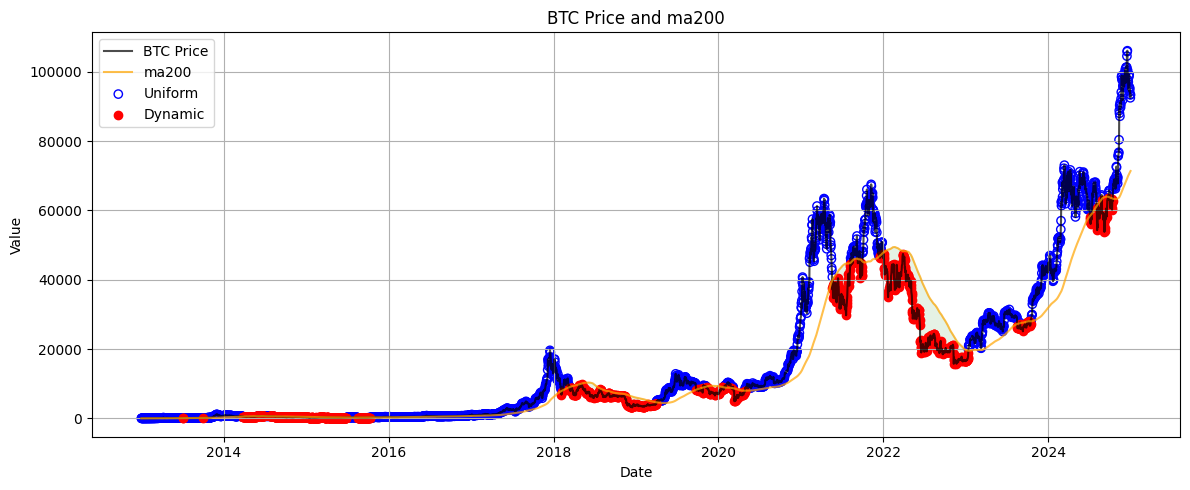

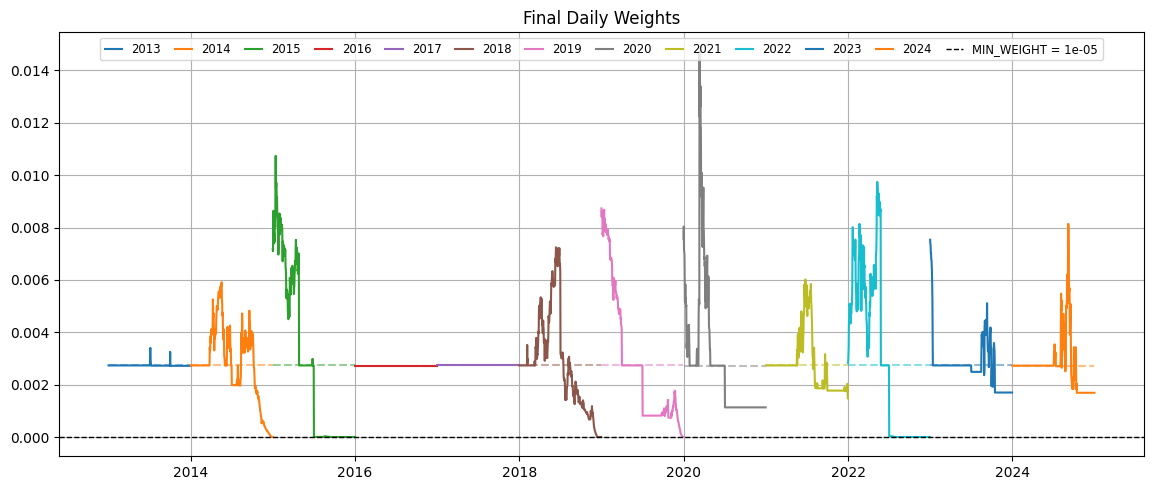

2025-05-20 12:11:22 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-20 12:11:22 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Cycle Weight Sums:
  2013: 1.0000
  2014: 1.0000
  2015: 1.0000
  2016: 1.0000
  2017: 1.0000
  2018: 1.0000
  2019: 1.0000
  2020: 1.0000
  2021: 1.0000
  2022: 1.0000
  2023: 1.0000
  2024: 1.0000


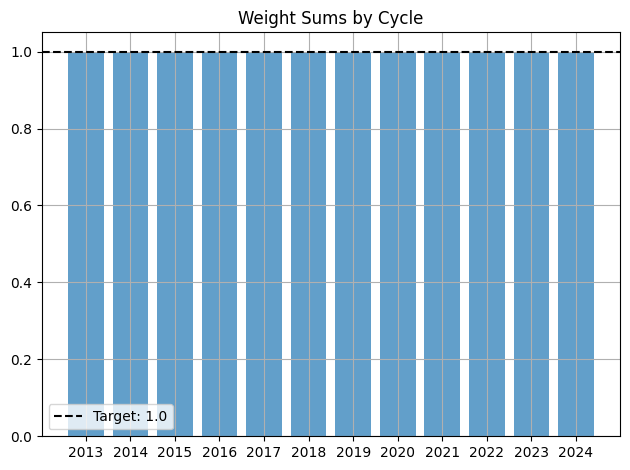


Aggregated Metrics for compute_weights:
Dynamic SPD:
  min: 1636.37
  max: 1575666.23
  mean: 206545.35
  median: 17324.64
Dynamic SPD Percentile:
  min: 16.53
  max: 62.17
  mean: 40.99
  median: 42.30

Excess SPD Percentile Difference (Dynamic – Uniform) per Cycle:
  2013: 0.02%
  2014: -4.42%
  2015: 9.45%
  2016: -0.00%
  2017: 0.00%
  2018: -6.01%
  2019: 25.11%
  2020: 13.23%
  2021: 6.89%
  2022: -28.62%
  2023: 5.08%
  2024: 3.03%
[2014] ❌ Dynamic SPD percentile (40.48%) is less than uniform (44.91%).
[2016] ❌ Dynamic SPD percentile (49.55%) is less than uniform (49.55%).
[2018] ❌ Dynamic SPD percentile (28.78%) is less than uniform (34.79%).
[2022] ❌ Dynamic SPD percentile (16.53%) is less than uniform (45.15%).
⚠️ Fix issues above.


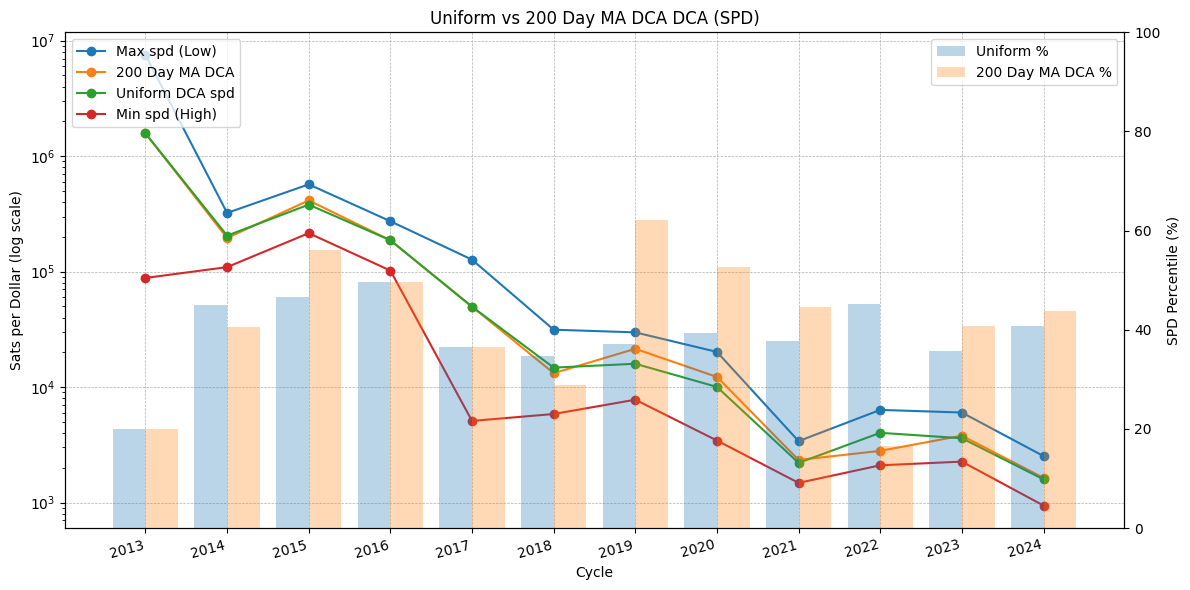

In [12]:
btc_df = load_data()
validate_price_data(btc_df)
btc_df = btc_df.loc[BACKTEST_START:BACKTEST_END]

weights = compute_weights(btc_df)

plot_features(df, weights=weights, start_date=BACKTEST_START, end_date=BACKTEST_END)
plot_final_weights(weights, start_date=BACKTEST_START)
plot_weight_sums_by_cycle(weights)

df_spd = backtest_dynamic_dca(btc_df, strategy_fn=compute_weights, strategy_label="compute_weights")
check_strategy_submission_ready(btc_df, strategy_fn=compute_weights)
plot_spd_comparison(df_spd, strategy_name="200 Day MA DCA")